# Custom umap projections

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import umap
import sklearn.datasets
from scipy.linalg import norm

from itertools import product
from functools import partial
from utils import multicore_apply

import plotly
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)

In [2]:
def create_vector_data(word_vectors):

    with open(word_vectors, 'r') as f:

        vector_data = f.read().strip().split('\n')
        rows, dims = vector_data[0].split()

        vector_data = [(word, [float(v) for v in vec.split()])
                       for word, vec in map(lambda s: s.split(' ', 1), vector_data[1:])]
        vector_data = pd.DataFrame(vector_data)

        vector_data.columns = ['word', 'vector']

        return vector_data
    

def create_word_counts(word_counts):

    result = []
    with open(word_counts, 'r') as f:
        for line in f.read().strip().split('\n'):
            count, word = line.strip().split()
            result.append({'word': word, 'count': int(count)})

    return pd.DataFrame.from_dict(result)

def normalize(x):
    x = np.array(x)
    return x / norm(x)

In [3]:
vector_data = create_vector_data('../data/papers/fasttext_cbow.vec')
word_counts = create_word_counts('../data/papers/word_counts.txt')
vector_data = vector_data.merge(word_counts, on = 'word', how = 'inner')
word_vectors = np.vstack(vector_data.vector.apply(normalize))
similarity_matrix = np.dot(word_vectors, word_vectors.transpose())

In [4]:
vector_data

,word,vector,count
0,te,"[-0.35124, -2.0889, -0.85395, 0.70495, -0.1470...",763159
1,i,"[-0.54016, -1.2133, 1.4153, 0.33749, 0.28364, ...",643138
2,e,"[-1.2252, 2.1587, 0.38373, 2.2331, 0.51481, -2...",388679
3,nga,"[0.71285, -1.5357, -0.20613, 1.2858, 0.28059, ...",356354
4,o,"[1.2408, -2.0103, 0.6315, -0.47112, 1.2881, 0....",355682
...,...,...,...
6608,ohe,"[-0.38828, -0.72377, -0.13417, -0.42688, -0.40...",37
6609,kokimako,"[0.056205, 0.13657, -0.11766, 0.27768, 0.32575...",30
6610,earawa,"[-0.78588, -1.1299, 0.11257, -0.33145, -0.4163...",36
6611,teiia,"[0.12013, 0.66628, -0.13984, 0.44661, -0.33809...",37


<AxesSubplot:xlabel='x_coord', ylabel='y_coord'>

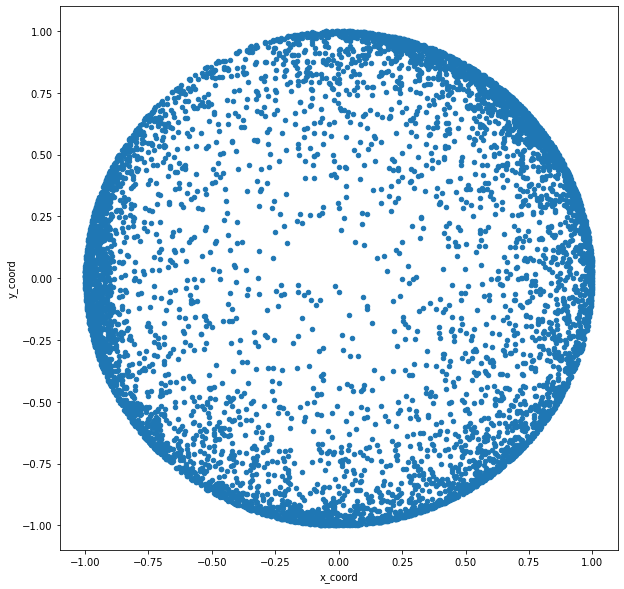

In [5]:
umap_data = pd.read_csv('../data/papers/umap.csv')
umap_data.plot(kind = 'scatter', x = 'x_coord', y = 'y_coord', figsize = (10,10))

In [7]:
def calculate_distance_matrix(A,B):
    p1 = np.sum(A**2, axis=1)[:, np.newaxis]
    p2 = np.sum(B**2, axis=1)
    p3 = -2 * np.dot(A, B.T)
    res = p1 + p2 + p3
    res[res<0] = 0
    res = np.sqrt(res)
    return res

<AxesSubplot:xlabel='x_coord', ylabel='y_coord'>

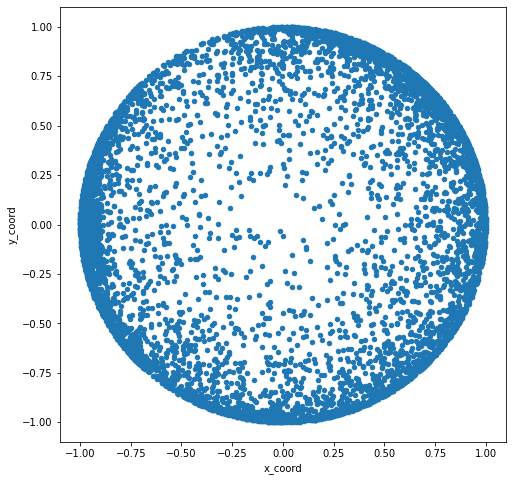

In [20]:
def rescale_point_map(umap_data):

    U = umap_data[['x_coord', 'y_coord']].values


    norms = calculate_distance_matrix(U, np.array([[0,0]]))
    # U = U * np.log(norms)
    U = U / norms ** 0.01

    # Scale point map so max_distance is 1
    radius = np.max(calculate_distance_matrix(U, U)) / 2
    U = U / radius

    # Scale point map to set max_norm == 1
    norms = calculate_distance_matrix(U, np.array([[0,0]]))
    U = U / np.max(norms)

    norms = calculate_distance_matrix(U, np.array([[0,0]]))

    umap_data['x_coord'] = U[:,0]
    umap_data['y_coord'] = U[:,1]

    return umap_data


umap_data = pd.read_csv('../data/papers/umap.csv')
umap_data = rescale_point_map(umap_data)

umap_data.plot(kind = 'scatter', x = 'x_coord', y = 'y_coord', figsize = (8,8))

In [10]:
umap_data['z_coord'] = np.sqrt(1 - umap_data.x_coord**2 - umap_data.y_coord**2)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

invalid value encountered in sqrt



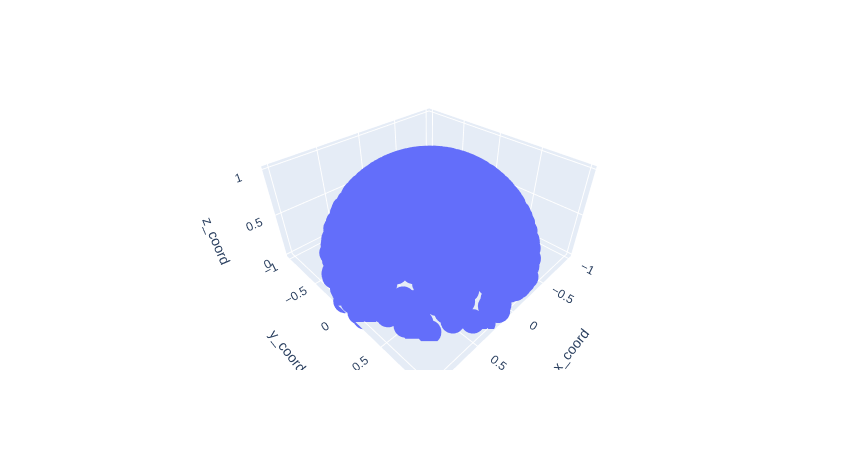

In [14]:
fig = px.scatter_3d(umap_data, x='x_coord', y='y_coord', z='z_coord')
fig